# 일반 모델의 변수 중요도
- Permutation Feature Importance


# 라이브러리 불러오기

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import *

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session

# 데이터 불러오기

In [98]:
data = pd.read_csv('./data/attrition2.csv')
data.head()

,Attrition,Age,Department,DistanceFromHome,Education,EducationField,Gender,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,RelationshipSatisfaction,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
0,0,28,Research & Development,1,3,Medical,Female,Research Scientist,1,Married,3591,1,3,3,3,3,3
1,1,37,Research & Development,2,2,Other,Male,Laboratory Technician,3,Single,2090,6,2,7,3,3,0
2,0,27,Research & Development,8,5,Life Sciences,Male,Laboratory Technician,3,Married,4621,1,4,3,4,3,3
3,0,18,Research & Development,1,3,Life Sciences,Female,Laboratory Technician,4,Single,1611,1,3,0,5,4,0
4,0,29,Research & Development,9,3,Life Sciences,Male,Research Scientist,3,Married,2451,6,1,5,2,2,1


|	변수 명	|	내용	|	구분	|  
|	----	|	----	|	----	|  
|	**Attrition**	|	이직여부, Yes = 1 , No = 0	|	**Target**	|  
|	Age	|	나이	|	숫자	|  
|	BusinessTravel	|	출장 빈도(범주)	|		|  
|	Department	|	현 부서	|		|  
|	DistanceFromHome	|	집-직장 거리(마일)	|	숫자	|  
|	Education	|	교육수준(범주)	|	1 Below College, 2 College, 3 Bachelor, 4 Master, 5 Doctor	|  
|	EducationField	|	전공	|		|  
|	EnvironmentSatisfaction	|	근무환경에 대한 만족도(범주)	|	1 Low, 2 Good, 3 Excellent, 4 Outstanding	|  
|	Gender	|	성별	|		|  
|	JobInvolvement	|	직무 적극성(참여도)	|	1 Low, 2 Medium, 3 High, 4 Very High	|  
|	JobRole	|	직무	|		|  
|	JobSatisfaction	|	직무 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|  
|	MaritalStatus	|	결혼상태	|		|  
|	MonthlyIncome	|	월급	|	숫자	|  
|	NumCompaniesWorked	|	현재까지 근무한 회사 수	|	숫자	|  
|	PercentSalaryHike	|	전년대비 급여인상율(%)	|	숫자	|  
|	RelationshipSatisfaction	|	동료와의 관계 만족도	|	1 Low, 2 Medium, 3 High, 4 Very High	|  
|	StockOptionLevel	|	스톡옵션 수준 0~3	|	범주	|  
|	TotalWorkingYears	|	총 근무 연수	|	숫자	|  
|	TrainingTimesLastYear	|	전년 교육훈련 횟수	|	숫자	|  
|	WorkLifeBalance	|	워라밸. 일-삶 균형도	|	1 Bad, 2 Good, 3 Better, 4 Best	|  
|	YearsAtCompany	|	현직장 근무 연수	|	숫자	|  
|	YearsInCurrentRole	|	현직무 연수	|	숫자	|  
|	YearsWithCurrManager	|	현 팀장과 근무한 연수	|	숫자	|  


# 필요한 함수 정의하기

In [99]:
# 변수 중요도 plot1
def plot_feature_importance(importance, names, topn = 'all'):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    plt.figure(figsize=(10,8))
    sns.barplot(x='feature_importance', y='feature_names', data = fi_df)

    plt.xlabel('importance')
    plt.ylabel('feature names')
    plt.grid()

    return fi_df

# 변수 중요도 plot2
def plot_PFI(pfi, col_names):
    plt.figure(figsize = (14,5))
    plt.subplot(1,2,1)
    for i,vars in enumerate(col_names) :
        sns.kdeplot(pfi.importances[i], label = vars)
    plt.legend()
    plt.grid()

    sorted_idx = pfi.importances_mean.argsort()
    plt.subplot(1,2,2)
    plt.boxplot(pfi.importances[sorted_idx].T, vert=False, labels=col_names[sorted_idx])
    plt.axvline(0, color = 'r')
    plt.grid()
    plt.show()

# 데이터 준비하기

##### x,y 나누기

In [100]:
target = 'Attrition'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [101]:
y.value_counts() / y.shape[0]

0    0.913043
1    0.086957
Name: Attrition, dtype: float64

##### 가변수화

In [102]:
dummy_vars = ['Education','Department','EducationField','Gender','JobRole','JobSatisfaction','MaritalStatus',
              'RelationshipSatisfaction','WorkLifeBalance'] # 가변수화 대상 변수 이름 리스트 만든다
x = pd.get_dummies(x, columns = dummy_vars, drop_first=True)

##### train, validation 분할

In [103]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state = 2023)

In [104]:
print(x_train.shape, x_val.shape)

(920, 38) (230, 38)


##### class balance를 맞추기 위한 resampling

In [105]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
sm_x_train, sm_y_train = smote.fit_resample(x_train, y_train)

##### 스케일링 하기

In [106]:
scaler = MinMaxScaler()
sm_x_train_s = scaler.fit_transform(sm_x_train)
x_val_s = scaler.transform(x_val)

# 모델링

* model1 : SVM
* model2 : KNN

In [107]:
from sklearn.inspection import permutation_importance

## 1. SVM 모델

In [108]:
model1 = SVC()
model1.fit(sm_x_train_s, sm_y_train)

SVC()

* permutation feature importance 구하기

In [109]:
pfi1 = permutation_importance(model1, x_val_s, y_val, n_repeats=10, random_state=2023)

In [110]:
pfi1

{'importances_mean': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.73913043e-03,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -4.34782609e-04,
         5.65217391e-03,  5.65217391e-03,  0.00000000e+00,  5.65217391e-03,
         1.73913043e-03,  8.26086957e-03, -4.34782609e-04,  7.39130435e-03,
         0.00000000e+00,  0.00000000e+00,  3.04347826e-03,  8.26086957e-03,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  2.17391304e-03,  0.00000000e+00,  4.34782609e-04,
        -5.21739130e-03,  1.30434783e-02,  2.22044605e-17,  0.00000000e+00,
         3.47826087e-03,  4.44089210e-17,  4.34782609e-03,  8.26086957e-03,
         1.30434783e-03,  0.00000000e+00]),
 'importances_std': array([0.        , 0.        , 0.        , 0.00212999, 0.        ,
        0.        , 0.        , 0.00304348, 0.00278397, 0.00339576,
        0.        , 0.00278397, 0.00212999, 0.00764278, 0.00130435,
        0.00436951, 0.       

* feature별 Score 분포

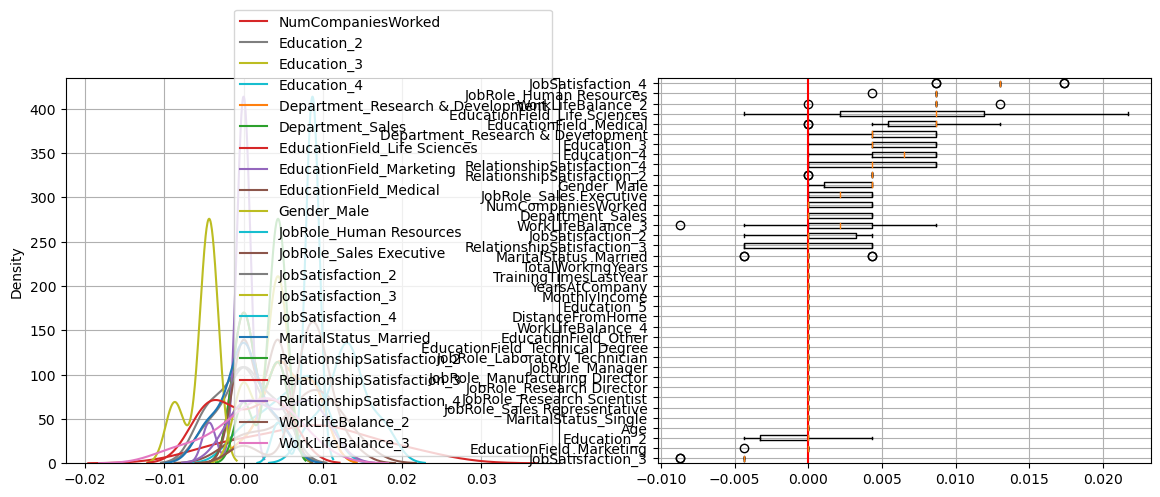

In [111]:
plot_PFI(pfi1, x.columns)

* 평균값으로 변수중요도 그래프 그리기

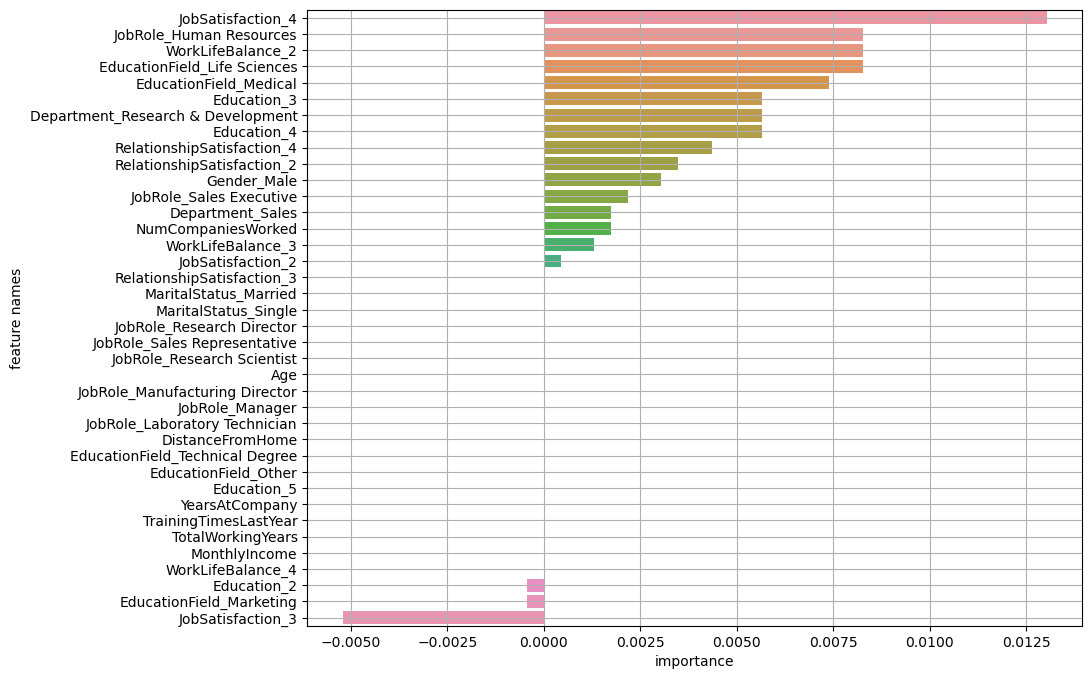

In [112]:
result = plot_feature_importance(pfi1.importances_mean, list(x_train))

## KNN 모델

In [113]:
model2 = KNeighborsClassifier()

model2.fit(sm_x_train_s, sm_y_train)

KNeighborsClassifier()

* permutation feature importance 구하기
    * deep learning 모델에 대해서는 명시적으로 scoring = 'r2'을 지정해 줘야 합니다.

In [114]:
pfi2 = permutation_importance(model2, x_val_s, y_val, n_repeats=10, random_state=2023)

In [115]:
pfi2

{'importances_mean': array([ 0.0026087 , -0.00391304,  0.01      ,  0.01434783,  0.00652174,
        -0.00217391,  0.00217391,  0.01826087,  0.01869565,  0.03652174,
         0.        ,  0.07130435,  0.00217391,  0.03869565,  0.01826087,
         0.03608696,  0.00304348,  0.00434783, -0.01434783,  0.01565217,
         0.01086957,  0.01565217,  0.00652174, -0.00173913,  0.01565217,
        -0.00521739, -0.00478261,  0.02869565,  0.01521739,  0.02782609,
         0.02347826, -0.00652174,  0.00304348,  0.02173913,  0.05304348,
         0.03956522,  0.04956522,  0.0173913 ]),
 'importances_std': array([0.00443393, 0.0073913 , 0.00551677, 0.01065883, 0.00350533,
        0.00486102, 0.0044552 , 0.00948584, 0.0121506 , 0.00732709,
        0.        , 0.01593939, 0.00707775, 0.01107629, 0.00576804,
        0.01580242, 0.00278397, 0.00336781, 0.01134608, 0.00212999,
        0.00707775, 0.00398485, 0.00558488, 0.00212999, 0.00484153,
        0.00638997, 0.00234138, 0.00620994, 0.01218167, 0.012

* feature별 Score 분포

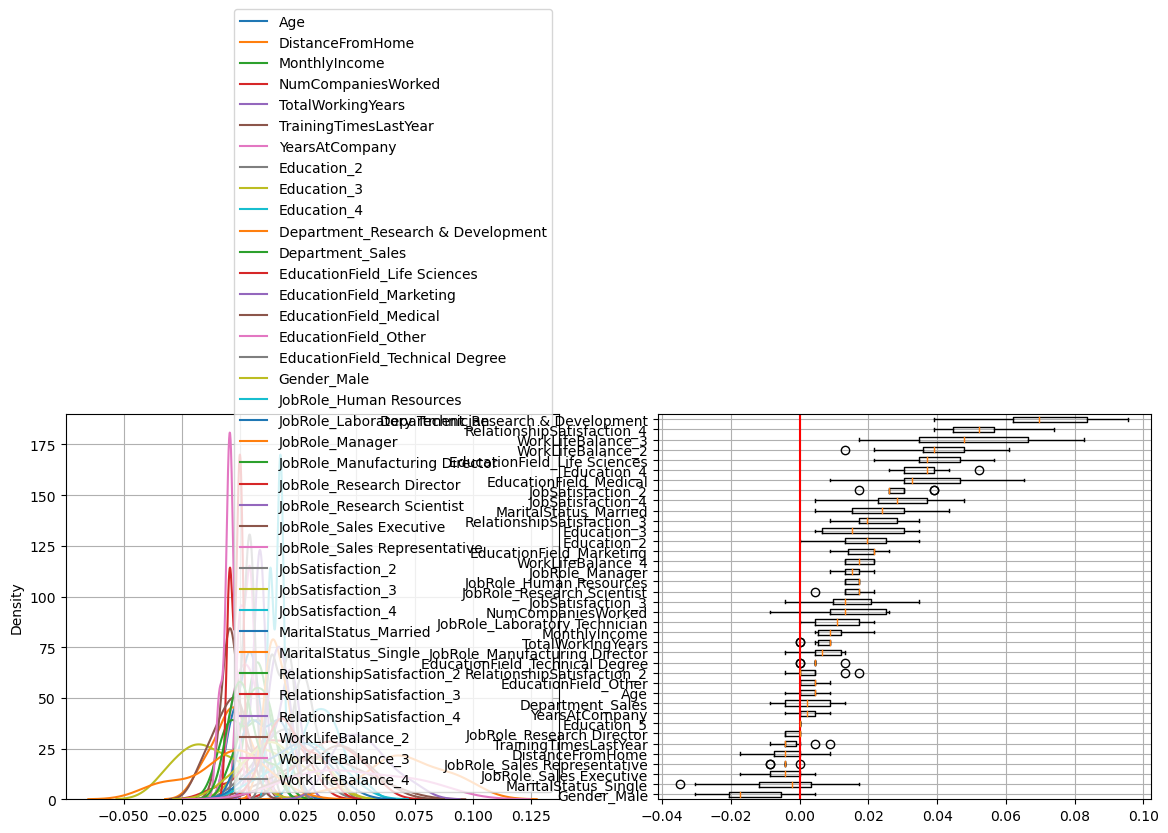

In [116]:
plot_PFI(pfi2, x.columns)

* 평균값으로 변수중요도 그래프 그리기

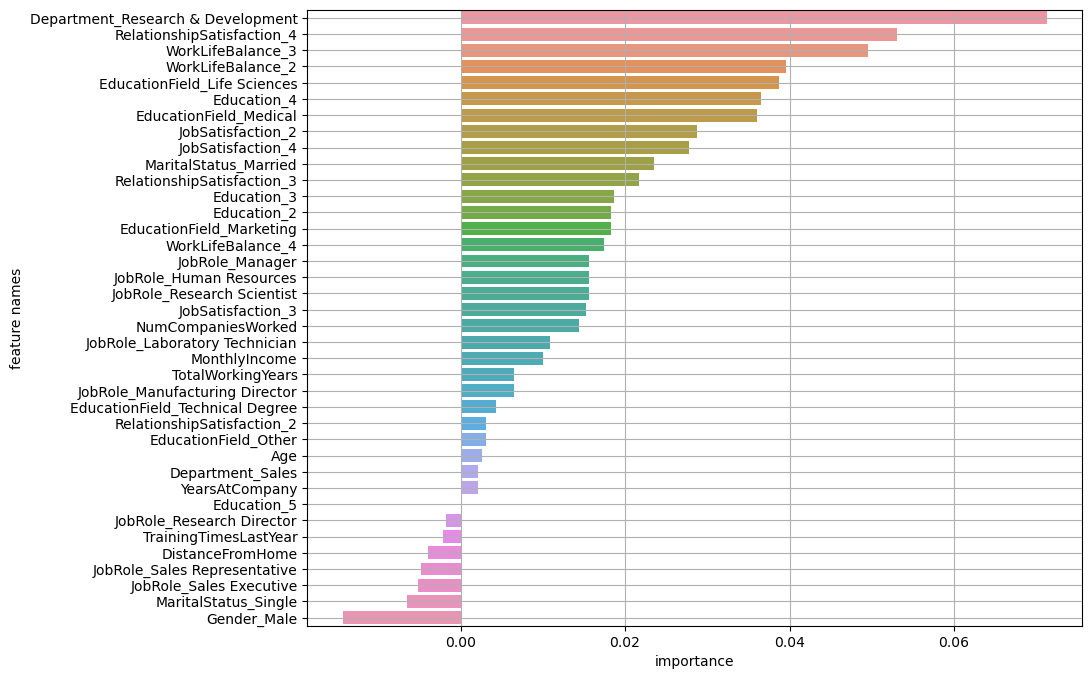

In [117]:
result = plot_feature_importance(pfi2.importances_mean, list(x_train))

# 모델 평가하기

In [121]:
from sklearn.metrics import *

In [122]:
pred1 = model1.predict(x_val_s)
print(classification_report(y_val, pred1))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       211
           1       0.00      0.00      0.00        19

    accuracy                           0.92       230
   macro avg       0.46      0.50      0.48       230
weighted avg       0.84      0.92      0.88       230



In [123]:
pred2 = model2.predict(x_val_s)
print(classification_report(y_val, pred2))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90       211
           1       0.21      0.42      0.28        19

    accuracy                           0.82       230
   macro avg       0.58      0.64      0.59       230
weighted avg       0.88      0.82      0.85       230

